##Install yfinance if not already installed

In [1]:
!pip install yfinance

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

## Define the Tickers and the Data Retrieval Period

In [8]:
tickers = [ "BTC-USD","ETH-USD"]

# Choose a start date far enough in the past to capture multiple Decembers
start_date = "2010-01-01"
end_date = datetime.today().strftime("%Y-%m-%d")


data = yf.download(tickers, start=start_date, end=end_date)

# The returned DataFrame typically has a multi-level column index:
# For example: ('Adj Close', '^IXIC'), ('Adj Close', 'BTC-USD'), etc.
# We'll focus on Adjusted Close prices.
adj_close = data['Adj Close']


[*********************100%***********************]  2 of 2 completed


## Calculate December Percentage Changes Each Year

December Percentage Returns for Each Year:


Ticker,BTC-USD,ETH-USD
Year,,
2014,-15.570938,NaN
2015,18.781030,NaN
2016,27.348852,NaN
2017,28.980656,62.201088
2018,-11.198296,12.418449
2019,-3.107277,-14.270444
2020,54.239875,25.621158
2021,-19.086870,-19.715704
2022,-2.473233,-6.229281


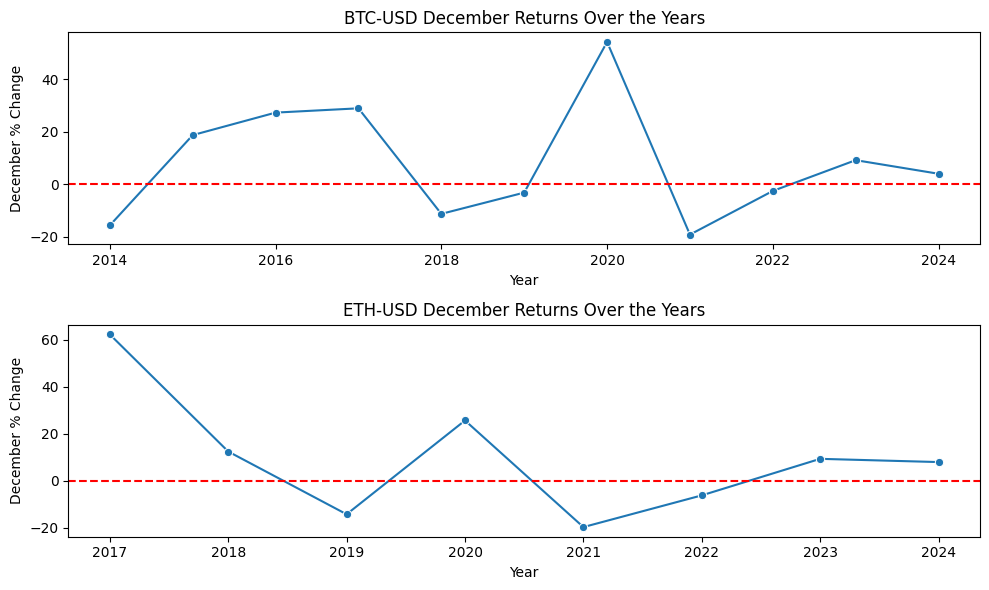

In [9]:
dec_mask = adj_close.index.month == 12
dec_data = adj_close[dec_mask]

# Group December data by year for processing
dec_data_by_year = dec_data.groupby(dec_data.index.year)


# Percentage change = (Last_Price_of_Dec - First_Price_of_Dec) / First_Price_of_Dec * 100%

dec_returns = {}
for year, df in dec_data_by_year:
    if len(df) > 1:
        first_prices = df.iloc[0]
        last_prices = df.iloc[-1]

        yearly_returns = (last_prices - first_prices) / first_prices * 100
        dec_returns[year] = yearly_returns

# Convert the dictionary to a DataFrame
dec_returns_df = pd.DataFrame(dec_returns).T
dec_returns_df.index.name = "Year"


# Display Results

print("December Percentage Returns for Each Year:")
display(dec_returns_df)


# Visualization
#
# Plot December returns over the years for each asset
fig, axes = plt.subplots(nrows=len(tickers), ncols=1, figsize=(10, 6))
if len(tickers) == 1:
    axes = [axes]  # Ensure axes is iterable even if there's only one ticker

for ax, ticker in zip(axes, tickers):
    sns.lineplot(x=dec_returns_df.index, y=dec_returns_df[ticker], marker='o', ax=ax)
    ax.set_title(f"{ticker} December Returns Over the Years")
    ax.set_ylabel("December % Change")
    ax.set_xlabel("Year")
    ax.axhline(y=0, color='red', linestyle='--')

plt.tight_layout()
plt.show()

## statistical significance test to determine whether the mean December returns for Bitcoin differ significantly from zero

In [15]:
!pip install yfinance statsmodels

import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
from scipy.stats import f_oneway, kruskal
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# ---------------------------------------
# Step 1: Download Data and Compute Monthly Returns
# ---------------------------------------
ticker = "BTC-USD"
start_date = "2014-01-01"
end_date = datetime.today().strftime("%Y-%m-%d")

data = yf.download(ticker, start=start_date, end=end_date)
adj_close = data['Adj Close']

# We need monthly returns for each year-month combination.
# Approach:
#  - Resample the data by month to get first and last day's price in each month.
#  - Compute monthly returns as (last_price - first_price) / first_price * 100%.

# Ensure we have daily data frequency (should be the case by default)
adj_close = adj_close.dropna()

# Group by year-month to find first and last prices of each month
# One way: use resample('M') which gives the last day of the month
# But we need first and last day specifically; we can do:
#   - first_day = adj_close.resample('M').first()
#   - last_day = adj_close.resample('M').last()
monthly_data = adj_close.rename(columns={'Adj Close': 'Price'})

# Extract year and month from the index
monthly_data['Year'] = monthly_data.index.year
monthly_data['Month'] = monthly_data.index.month

# Group by Year and Month
grouped = monthly_data.groupby(['Year', 'Month'])

# Compute monthly returns
monthly_returns = []
for (yr, mth), df_m in grouped:
    if len(df_m) > 1:
        # Access the 'Price' column correctly.
        # df_m contains the prices directly, so you don't need another column
        first_price = df_m.iloc[0][0]
        last_price = df_m.iloc[-1][0]
        m_return = (last_price - first_price) / first_price * 100
        monthly_returns.append([yr, mth, m_return])

monthly_returns_df = pd.DataFrame(monthly_returns, columns=['Year', 'Month', 'Return'])

# ---------------------------------------
# Step 2: Analyze Seasonality Across All Months
# ---------------------------------------
# We now have a DataFrame with monthly returns for each year and month.
# We can perform an ANOVA test to see if there's a difference between months.

# Organize data by month
month_groups = [group["Return"].dropna().values for _, group in monthly_returns_df.groupby('Month')]

# One-way ANOVA
f_stat, p_value = f_oneway(*month_groups)
print("One-way ANOVA across months:")
print("F-statistic:", f_stat)
print("P-value:", p_value)

if p_value < 0.05:
    print("Significant differences found between months at α=0.05.")
else:
    print("No significant differences found between months.")

# ---------------------------------------
# Step 3: Post-hoc Tests (If ANOVA is Significant)
# ---------------------------------------
# If ANOVA shows significance, we can use Tukey's test to identify which months differ.
# Note: Even if ANOVA is not significant, we show how you would do it.

if p_value < 0.05:
    # Prepare data for Tukey's HSD
    # Tukey’s test requires a single array of values and an array of the corresponding group labels.
    tukey_data = monthly_returns_df.dropna()
    tukey_test = pairwise_tukeyhsd(endog=tukey_data['Return'], groups=tukey_data['Month'], alpha=0.05)
    print(tukey_test)

    # If you specifically want to compare December (Month=12) to others:
    # Extract December returns
    dec_returns = tukey_data.loc[tukey_data['Month'] == 12, 'Return']
    # Extract returns for other months
    other_months = tukey_data.loc[tukey_data['Month'] != 12, 'Return']

    # You can do a two-sample t-test comparing December vs. rest of the year:
    from scipy.stats import ttest_ind
    t_stat_dec, p_val_dec = ttest_ind(dec_returns, other_months, equal_var=False)
    print("\nComparing December returns to all other months:")
    print("T-statistic:", t_stat_dec)
    print("P-value:", p_val_dec)
    if p_val_dec < 0.05:
        print("December returns significantly differ from other months at α=0.05.")
    else:
        print("No significant difference for December vs. other months.")
else:
    print("ANOVA not significant, so we do not proceed with post-hoc tests.")


# ---------------------------------------
# Optional: Non-Parametric Test (Kruskal-Wallis)
# ---------------------------------------
# If the data is non-normal or you prefer a non-parametric approach:
kw_stat, kw_p_val = kruskal(*month_groups)
print("\nKruskal-Wallis Test across months:")
print("Statistic:", kw_stat)
print("P-value:", kw_p_val)


[*********************100%***********************]  1 of 1 completed

One-way ANOVA across months:
F-statistic: 1.152250998569176
P-value: 0.3285859619369555
No significant differences found between months.
ANOVA not significant, so we do not proceed with post-hoc tests.

Kruskal-Wallis Test across months:
Statistic: 16.070604105571817
P-value: 0.1385299031625263



<ipython-input-15-375a330d07f8>:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_price = df_m.iloc[0][0]
<ipython-input-15-375a330d07f8>:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  last_price = df_m.iloc[-1][0]
